In [7]:
# Nikhil Patil
# CSEC 620
# Project 1 New Model
'''
this model is far more efficient than my previous one. 
It uses the same dataset, but it uses the clean_df function from the dataprep library to clean the dataset as well all 77 features rather than just 4.  
The larger sequential keras model versus functional keras model aids in efficiency as well. 

'''

# Import the necessary libraries
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dataprep.clean import clean_df

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_score, recall_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


warnings.filterwarnings("ignore") # ignore warnings

dataset_csv_path = 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv' # the dataset used for this model. 

# Load and clean the dataset 
df = pd.read_csv(dataset_csv_path)
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace("/", "", regex=False) 
df = clean_df(df,data_type_detection = "none", standardize_missing_values = "remove") 
'''
The clean_df function is used to clean the dataset. The data_type_detection parameter is set to "none" because of the way that clean_df returns the dataframe.
standardize_missing_values is set to "remove" to remove rows with missing values.
'''

# create list of features
features = []
for column in df.columns:
    features.append(column)

df.replace([np.inf, -np.inf], np.nan, inplace=True) # replace infinite values with Not a Number (NaN)
df.fillna(0, inplace=True) # fill values with 0 

df = df[features]
df_features = df.drop('label', axis=1) # drop the label column
df_labels = df['label'] # get the label column


# Begin to fit the model
scaler = StandardScaler() 
transformed_features = scaler.fit_transform(df_features)

# Encode the Label column
encoder = OneHotEncoder(sparse_output=False)
labels_encoded = encoder.fit_transform(df_labels.values.reshape(-1,1))

# Use train_test_split from scikit-learn to split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(transformed_features, labels_encoded, train_size= .8, test_size=0.2)

# Create the model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(labels_encoded.shape[1], activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
start_time = time.perf_counter()
model.fit(X_train, y_train, epochs=10, batch_size=32)
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
end_time = time.perf_counter()

print(f"Loss: {loss: .8f}, Accuracy: {accuracy: .12f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")


Column Headers Cleaning Report:
	77 values cleaned (97.47%)
Number of Entries Cleaning Report:
	4 entries dropped (0.0%)
Downcast Memory Report:
	Memory reducted from 174241739 to 98844245. New size: (56.73%)
Epoch 1/10
5644/5644 [==============================] - 17s 3ms/step - loss: 0.0171 - accuracy: 0.9960
Epoch 2/10
5644/5644 [==============================] - 16s 3ms/step - loss: 0.0081 - accuracy: 0.9985
Epoch 3/10
5644/5644 [==============================] - 16s 3ms/step - loss: 0.0076 - accuracy: 0.9987
Epoch 4/10
5644/5644 [==============================] - 17s 3ms/step - loss: 0.0076 - accuracy: 0.9988
Epoch 5/10
5644/5644 [==============================] - 17s 3ms/step - loss: 0.0068 - accuracy: 0.9989
Epoch 6/10
5644/5644 [==============================] - 17s 3ms/step - loss: 0.0064 - accuracy: 0.9988
Epoch 7/10
5644/5644 [==============================] - 18s 3ms/step - loss: 0.0065 - accuracy: 0.9988
Epoch 8/10
5644/5644 [==============================] - 18s 3ms/step -

In [8]:
# Collect the classification report
# Code was taken from CNN model that shared as an example
preds = model.predict(X_test, batch_size=32, verbose=0)
y_true_labels = [np.argmax(t) for t in y_test]
y_preds_labels = [np.argmax(t) for t in preds]
class_metric_report = classification_report(y_true_labels, y_preds_labels, target_names=['BENIGN','DDoS'], digits=4)
print(class_metric_report)

              precision    recall  f1-score   support

      BENIGN     0.9986    0.9996    0.9991     19652
        DDoS     0.9997    0.9989    0.9993     25497

    accuracy                         0.9992     45149
   macro avg     0.9992    0.9993    0.9992     45149
weighted avg     0.9992    0.9992    0.9992     45149



1411/1411 [==============================] - 2s 1ms/step


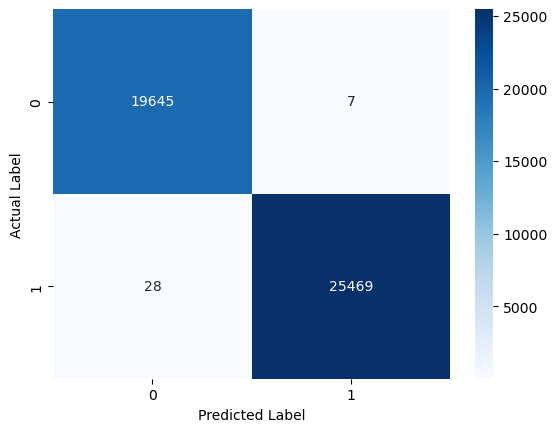

<Figure size 640x480 with 0 Axes>

In [9]:
# Plot the confusion matrix
y_pred_prob = model.predict(X_test)
y_pred = np.where(y_pred_prob > .5, 1, 0)


# Since the labels are one-hot encoded, change them into a binary classification 
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred_prob, axis=1) 

# Calculate Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_class)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

plt.savefig('confusion_matrix.png', dpi=400)